In [1]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE, colors, etc.
from faculty_hiring.misc.productivity import *
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

import numpy as np
import scipy as sp
import palettable

from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from collections import Counter

In [2]:
faculty_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/faculty_cs_CURRENT.txt'
inst_file = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/current_data/inst_cs_CURRENT.txt'
figures_dir = '/Users/allisonmorgan/Code/src/github.com/samfway/faculty_hiring/notebooks-productivity/figures/'

# Path to prepped DBLP pickles
dblp_dir = '/Users/allisonmorgan/Documents/faculty_hiring/publication_data/profiles_DBLP_Nov16/'

In [3]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)  # This takes a minute..

# Total Number of Publications

In [4]:
# Number of publications for all current assistant faculty of a university. Adjusted for inflation
ignore = ['All others', 'UNKNOWN', 'CUNY Graduate Center']
pubs_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []
    for person in current_faculty:
        start = person.first_asst_job_year
        if person.__contains__('dblp_pubs'):
            contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                    contribution += inflation_adjust(pub['year'])
            n_pubs.append((person.facultyName, contribution))
    if len(n_pubs) > 0:
        pubs_by_inst[name] = n_pubs

### Prestige

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Line of best fit has a slope of -0.2654 and a r^2 of 0.3501


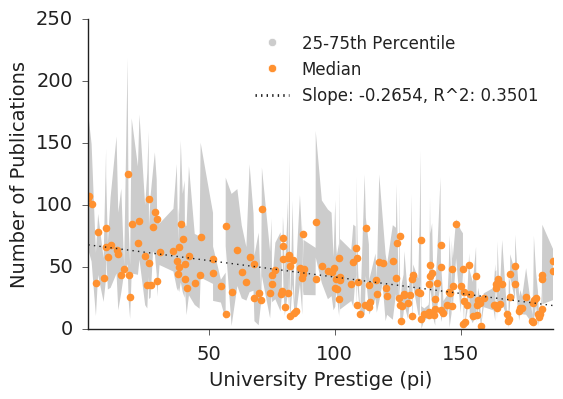

In [5]:
plot_pubs_versus_prestige(pubs_by_inst, 'Number of Publications', function=np.median, percentiles=True, fit=True)

# Fractional Author Contribution

In [6]:
# Fractional contribution of publications for all current assistant faculty of a university
frac_pubs_by_inst = {};
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    frac_n_pubs = []
    for person in current_faculty:
        start = person.first_asst_job_year
        if person.__contains__('dblp_pubs'):            
            frac_contribution = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                    frac_contribution += inflation_adjust(pub['year'])/float(len(pub['authors']))
            frac_n_pubs.append((person.facultyName, frac_contribution))
            
    if len(n_pubs) > 0:
        frac_pubs_by_inst[name] = frac_n_pubs

### Prestige

Line of best fit has a slope of -0.0955 and a r^2 of 0.3214


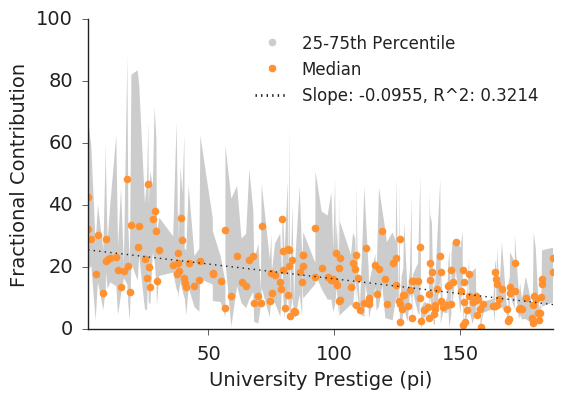

In [11]:
plot_pubs_versus_prestige(frac_pubs_by_inst, 'Fractional Contribution', function=np.median, percentiles=True, fit=True)

# Exclude Middle Author Role From Number of Publications

In [8]:
# Number of publications for all current assistant faculty of a university
first_and_last_pubs_by_inst = {}
for (name, inst_data) in inst.items():
    if name in ignore:
        continue
    current_faculty = faculty_at_institution(name, asst_faculty)
    n_pubs = []
    for person in current_faculty:
        start = person.first_asst_job_year
        if person.__contains__('dblp_pubs'):
            first_and_last_contributions = 0
            for pub in person.dblp_pubs:
                if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and pub['pub_type'] in ['inproceedings', 'article']:
                    if pub['author_role'] != 1:
                        first_and_last_contributions += inflation_adjust(pub['year'])
            n_pubs.append((person.facultyName, first_and_last_contributions))
    
    if len(n_pubs) > 0:
        first_and_last_pubs_by_inst[name] = n_pubs

### Prestige

Line of best fit has a slope of -0.1858 and a r^2 of 0.3344


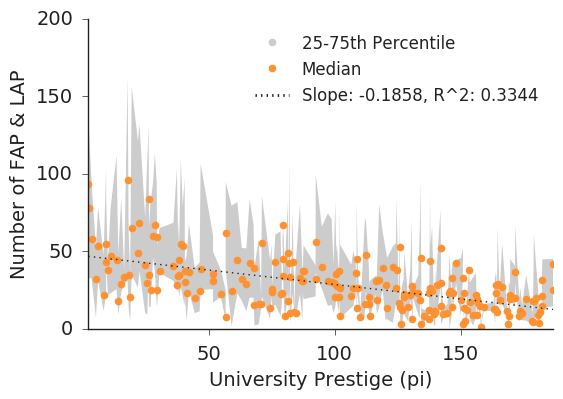

In [9]:
plot_pubs_versus_prestige(first_and_last_pubs_by_inst, 'Number of FAP & LAP', function=np.median, percentiles=True, fit=True)